In [1]:
#Load library and configuration parameters
#Denoising autoencoder
import torch
import torch.nn as nn
import torch.utils as utils
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import scipy.io as sio

import os
import cv2

In [2]:
# Classes

# Target dataset
class CustomDataset(Dataset):

    def __init__(self, set_selection=0):
        
        target_path = '../30-Video_Feature_Generation/'
        data_meta = pd.read_csv(target_path +'output/UCSDped2/meta_data.csv')      
        self.data = []
        
        if set_selection == 0:
            # get only train
            n_start = 0
            n_end = data_meta[data_meta['train_valid_test']=='valid'].index[0]
        elif set_selection == 1:
            # get only validation
            n_start = data_meta[data_meta['train_valid_test']=='valid'].index[0]
            n_end = data_meta[data_meta['train_valid_test']=='test'].index[0]
        else:
            # get everything, including test set
            n_start = 0
            n_end = len(data_meta)
            
        # read all data 
        for i in range(n_start, n_end):
            img_path = target_path + data_meta.loc[i, 'scaled_im_path'][2:]
            class_name = data_meta.loc[i, 'name']
            self.data.append([img_path, class_name])
            
        # read class types
        tmp = data_meta[['name','class']].drop_duplicates().sort_values(by='class').reset_index(drop=True)
        class_map_ = dict()
        for i in range(0, len(tmp)):
            name_ = tmp.loc[i, 'name']
            class_ = int(tmp.loc[i, 'class'])
            class_map_[name_] = class_
            
        self.class_map = class_map_
        self.img_dim = (64, 64)
        
    def __len__(self):
        
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        # read
        img = cv2.imread(img_path, 0)
        # resize
        img = cv2.resize(img, self.img_dim)
        # normalize
        img = img/255.0
        # cast to float
        img = img.astype('float32')
        # expan dim
        img = np.expand_dims(img, axis=0)
        
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)
        #img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        
        return img_tensor, class_id
    
# Encoder settings
class Encoder(nn.Module):
    
    def __init__(self):
        
        super(Encoder,self).__init__()
        
        self.conv1=nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        
        self.maxpool1 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        self.conv2 = nn.Sequential(
            torch.nn.Conv2d(64, 50, 3, 1, 1),  
            torch.nn.BatchNorm2d(50),
            torch.nn.LeakyReLU(0.2))
        
        self.maxpool2 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        self.conv3 = nn.Sequential(
            torch.nn.Conv2d(50, 36, 3, 1, 1),
            torch.nn.BatchNorm2d(36),
            torch.nn.LeakyReLU(0.2))
        
        self.maxpool3 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        self.conv4 = nn.Sequential(
            torch.nn.Conv2d(36,22, 3, 1, 1),  
            torch.nn.BatchNorm2d(22),
            torch.nn.LeakyReLU(0.2))
        
        self.maxpool4 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        self.conv5 = nn.Sequential(
            torch.nn.Conv2d(22, 8, 3, 1, 1),
            torch.nn.BatchNorm2d(8),
            torch.nn.Sigmoid())
        
        self.maxpool5 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
    def forward(self, x_in):
        
        x = self.conv1(x_in)
        x , indices1 = self.maxpool1(x)
        x = self.conv2(x)
        x , indices2 = self.maxpool2(x)
        x = self.conv3(x)
        x , indices3 = self.maxpool3(x)
        x = self.conv4(x)
        x , indices4 = self.maxpool4(x)
        x = self.conv5(x)
        feature , indices5 = self.maxpool5(x)
        
        indices = [indices1, indices2, indices3, indices4, indices5]
        
        return feature, indices
    
# Decoder settings
class Decoder(nn.Module):
    
    def __init__(self):
        
        super(Decoder,self).__init__()
        
        self.convtrans1 = nn.Sequential(nn.ConvTranspose2d(8, 22, 3, 1, 1), )
        
        self.maxunpool1= nn.MaxUnpool2d(2, stride=2)
        
        self.convtrans2 = nn.Sequential(nn.ConvTranspose2d(22, 36, 3, 1, 1), )
        
        self.maxunpool2 = nn.MaxUnpool2d(2,stride=2)
        
        self.convtrans3 = nn.Sequential(nn.ConvTranspose2d(36, 50, 3, 1, 1), )
        
        self.maxunpool3 = nn.MaxUnpool2d(2, stride=2)
        
        self.convtrans4 = nn.Sequential(nn.ConvTranspose2d(50, 64, 3, 1, 1), )
        
        self.maxunpool4 = nn.MaxUnpool2d(2,stride=2)
        
        self.convtrans5 = nn.Sequential(nn.ConvTranspose2d(64, 1, 3, 1, 1), )
        
        self.maxunpool5 = nn.MaxUnpool2d(2,stride=2)
        
    def forward(self, x_in, indices):
        
        x = self.maxunpool1(x_in, indices[4])
        x = self.convtrans1(x)
        x = self.maxunpool2(x, indices[3])
        x = self.convtrans2(x)
        x = self.maxunpool3(x, indices[2])
        x = self.convtrans3(x)
        x = self.maxunpool4(x, indices[1])
        x = self.convtrans4(x)
        x = self.maxunpool5(x, indices[0])
        x = self.convtrans5(x)
        
        return x

In [3]:
#Configuration parameter

n_epoch = 20                # Number of epochs
batch_size = 256            # Size of the batch
learning_rate = 0.01        # learning rate for ADAM optimizer
noise_std = 0.01            # This noise level is given in "https://arxiv.org/pdf/2012.01468.pdf"
target_data_name = 'UCSDped2'

In [4]:
# Read Meta data 
data_meta = pd.read_csv('./output/' + target_data_name + '/meta_data.csv')

# Read Yolo Objects and create torch datasets
data_train = CustomDataset(set_selection=0)
train_loader = DataLoader(data_train, batch_size = batch_size, shuffle=True)

data_valid = CustomDataset(set_selection=1)
valid_loader = DataLoader(data_valid, batch_size = batch_size, shuffle=True)

data_all = CustomDataset(set_selection=2)
all_loader = DataLoader(data_all, batch_size = batch_size, shuffle=True)

In [5]:
# Create the Autoencoder
encoder=Encoder().cuda()
decoder=Decoder().cuda()

# Loss functions and optimizers
parameters=list(encoder.parameters())+list(decoder.parameters())
loss_func=nn.MSELoss()
optimizer=torch.optim.Adam(parameters, lr=learning_rate)

# Autoencoder training

# Create performance save arrays
train_loss_acc = []
valid_loss_acc = []

for I in range(n_epoch):
    
    # run epoch
    print('Epoch: {}'.format(I))
    train_loss = 0.0
    for image,label in tqdm(train_loader):
        
        # create noise
        noise=torch.tensor(np.random.normal(loc=0, scale=noise_std, size=image.shape)).type(torch.FloatTensor)
        
        # create noise image
        image_n=torch.add(image, noise)
        
        # move images to GPU
        image=Variable(image).cuda()
        image_n=Variable(image_n).cuda()
        
        # clear gradients
        optimizer.zero_grad()
        
        # forward pass from DAE (encoder + decoder)
        latent_features, indices = encoder(image_n)
        output = decoder(latent_features, indices)
        
        # get loss
        loss = loss_func(output,image)
        
        # calculate gradients based on loss
        loss.backward()
        
        # Update Weights
        optimizer.step()
        
        # save training loss
        train_loss = train_loss + loss.item()
    
    # average train loss
    avg_train_loss = train_loss/image.shape[0]
    train_loss_acc.append(avg_train_loss)
    
    # calculate validation loss after epoch is completed
    print('Running validation...')
    valid_loss = 0.0
    for image_v, labels_v in valid_loader:
        
        # move images to GPU
        image_v=Variable(image_v).cuda()
        
        # forward pass from DAE (encoder + decoder)
        latent_features_v, indices_v = encoder(image_v)
        output_v = decoder(latent_features_v, indices_v)
        
        # get loss
        loss_v = loss_func(output_v, image_v)
        
        # save valid loss
        valid_loss = valid_loss + loss_v.item()
    
    # average valid loss
    avg_valid_loss = valid_loss/image_v.shape[0]
    valid_loss_acc.append(avg_valid_loss)

Epoch: 0


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.56it/s]


Running validation...
Epoch: 1


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


Running validation...
Epoch: 2


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.28it/s]


Running validation...
Epoch: 3


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.23it/s]


Running validation...
Epoch: 4


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.33it/s]


Running validation...
Epoch: 5


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


Running validation...
Epoch: 6


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.18it/s]


Running validation...
Epoch: 7


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.32it/s]


Running validation...
Epoch: 8


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.34it/s]


Running validation...
Epoch: 9


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.36it/s]


Running validation...
Epoch: 10


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


Running validation...
Epoch: 11


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.30it/s]


Running validation...
Epoch: 12


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.39it/s]


Running validation...
Epoch: 13


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.32it/s]


Running validation...
Epoch: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


Running validation...
Epoch: 15


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


Running validation...
Epoch: 16


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


Running validation...
Epoch: 17


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.38it/s]


Running validation...
Epoch: 18


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.34it/s]


Running validation...
Epoch: 19


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.29it/s]


Running validation...


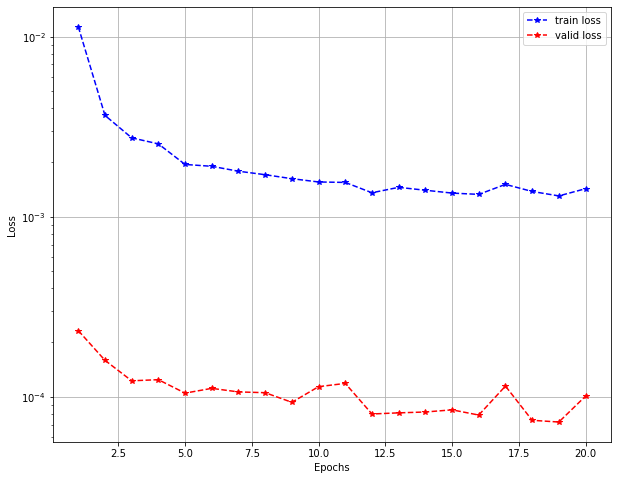

In [6]:
# create performance watch
x_epoch = list(range(1,n_epoch+1))
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.plot(x_epoch, train_loss_acc, '--*b', label='train loss')
ax.plot(x_epoch, valid_loss_acc, '--*r', label='valid loss')
plt.yscale("log")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

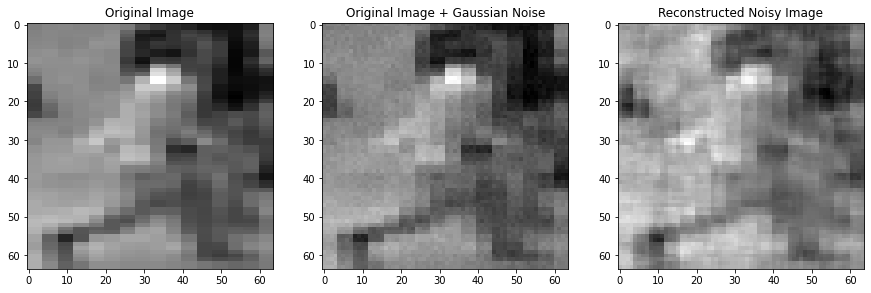

In [7]:
# Test couple of examples
test_image_index = 1
img=image[test_image_index].cpu()
input_img=image_n[test_image_index].cpu()
output_img=output[test_image_index].cpu()

origin=img.data.numpy()
inp=input_img.data.numpy()
out=output_img.data.numpy()

f, axs = plt.subplots(1,3,figsize=(15,15))
axs[0].imshow(origin[0],cmap='gray')
axs[0].set_title('Original Image')

axs[1].imshow(inp[0],cmap='gray')
axs[1].set_title('Original Image + Gaussian Noise')

axs[2].imshow(out[0],cmap='gray')
axs[2].set_title('Reconstructed Noisy Image')
plt.show()

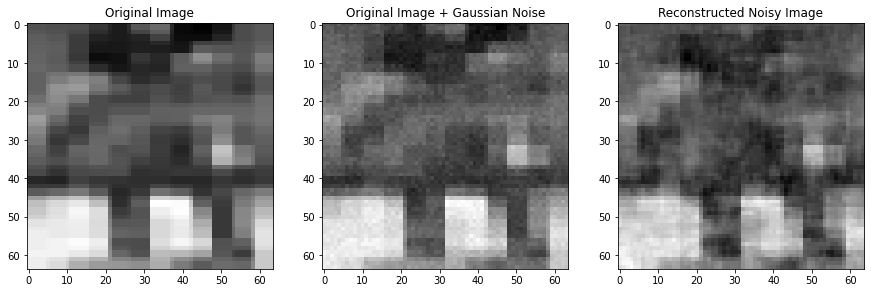

In [9]:
# Test couple of examples
test_image_index = 80
img=image[test_image_index].cpu()
input_img=image_n[test_image_index].cpu()
output_img=output[test_image_index].cpu()

origin=img.data.numpy()
inp=input_img.data.numpy()
out=output_img.data.numpy()

f, axs = plt.subplots(1,3,figsize=(15,15))
axs[0].imshow(origin[0],cmap='gray')
axs[0].set_title('Original Image')

axs[1].imshow(inp[0],cmap='gray')
axs[1].set_title('Original Image + Gaussian Noise')

axs[2].imshow(out[0],cmap='gray')
axs[2].set_title('Reconstructed Noisy Image')
plt.show()

In [ ]:
# project all available data to latent space

n=len(data_all)
latents = np.zeros((n, 33)) #32 latent features + PSNR

for i in tqdm(range(n)):
    
    # get the sample
    sample, _ = data_all[i]
    sample = sample.cpu()
    tmp = np.expand_dims(sample, axis=0)   
    sample = torch.from_numpy(tmp)
    sample = Variable(sample).cuda()
    
    # get latent features
    latent_features, indices = encoder(sample)
    
    # get decoded image
    output = decoder(latent_features, indices)
    
    # save features
    z1 = latent_features.resize(1,32).cpu().detach().numpy()[0]
    latents[i,0:32] = z1
    
    mse = torch.mean(torch.pow(torch.sub(sample, output), 2)).cpu().detach().numpy()
    max_x = sample.max().cpu().detach().numpy()
    z2 = 10*np.log10(max_x/mse) # PSNR
    latents[i,32] = z2
    
# combine meta data and latent features
latent_pd = pd.DataFrame(latents, columns=['dae_latent_feature_{:02d}'.format(x) for x in range(33)])
latent_pd.rename(columns={'dae_latent_feature_32': 'spnr'}, inplace=True)
video_df = pd.concat([data_meta,latent_pd], axis=1)

In [9]:
# save output as mat to be used in matlab
out_df = {name: col.values for name, col in ped2_df.items()}
sio.savemat('./output/' + target_data_name + '/' + target_data_name + '_dae.mat', out_df)